 # Opis notatnika
 Sprawdzenie między innymi to, czy opóźnienia lotów zależne są od trasy czy warunków pogodowych.

In [1]:
import pandas as pd
import psycopg2
import matplotlib as plt
import matplotlib.pyplot as plt

from sqlalchemy import create_engine

In [2]:
username = ''
password = ''

host = 'localhost'
database = 'airlines'
port = 5432

try:
    con = psycopg2.connect(user=username, password=password, host=host, database=database)
    cursor = con.cursor()
    print("Połączenie z bazą danych udane!")
except psycopg2.Error as e:
    print(f"Błąd połączenia: {e}")

Połączenie z bazą danych udane!


In [3]:
url = f"postgresql://{username}:{password}@{host}:{port}/{database}"
engine = create_engine(url)

Implementacja metody `read_sql_table`

In [4]:
def read_sql_table(table_name):
    df = pd.read_sql(table_name, con = engine)
    return df

In [5]:
flight_df = pd.read_csv(r'..\data\processed\flight_df_02.csv',sep=';', decimal='.' )

flight_df

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,is_delayed,is_weekend,distance_agg,manufacture_year,manufacture_year_agg
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,NaN,NaN,NaN,NaN,2019,False,True,1100-1199,2005.0,2004.0
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,NaN,NaN,NaN,NaN,2019,False,True,1100-1199,2016.0,2016.0
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,0.0,10.0,0.0,3.0,2019,False,True,1100-1199,1998.0,1998.0
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,NaN,NaN,NaN,NaN,2019,False,True,1100-1199,1998.0,1998.0
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,NaN,NaN,NaN,NaN,2019,False,True,500-599,2001.0,2001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057386,1382967,12,11,3,DL,N321DH,1826,13303,10397,1807,...,NaN,NaN,NaN,NaN,2019,False,False,500-599,2017.0,2016.0
1057387,1382968,12,11,3,DL,N329NW,1982,13303,12953,1959,...,0.0,19.0,0.0,0.0,2019,True,False,1000-1099,1992.0,1992.0
1057388,1382969,12,11,3,DL,N331NW,1987,13303,10397,1125,...,NaN,NaN,NaN,NaN,2019,False,False,500-599,1992.0,1992.0
1057389,1382970,12,11,3,DL,N309DN,2151,13303,12953,700,...,0.0,66.0,0.0,0.0,2019,True,False,1000-1099,2016.0,2016.0


In [6]:
flight_df_expected_rows_amount = 1057391
flight_df_rows_amount = flight_df.shape[0]

assert flight_df_rows_amount == flight_df_expected_rows_amount, f'Oczekiwano {flight_df_expected_rows_amount} wierszy, otrzymano {flight_df_rows_amount}'

In [7]:
flight_df.columns

Index(['id', 'month', 'day_of_month', 'day_of_week', 'op_unique_carrier',
       'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
       'crs_dep_time', 'dep_time', 'dep_delay', 'dep_time_blk', 'crs_arr_time',
       'arr_time', 'arr_delay_new', 'arr_time_blk', 'cancelled',
       'crs_elapsed_time', 'actual_elapsed_time', 'distance', 'distance_group',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'year', 'is_delayed', 'is_weekend',
       'distance_agg', 'manufacture_year', 'manufacture_year_agg'],
      dtype='object')

 # Wzbogacenie o `airport_list`

In [8]:
airport_list_df = read_sql_table('airport_list')

In [9]:
airport_list_df.columns

Index(['id', 'origin_airport_id', 'display_airport_name', 'origin_city_name',
       'name'],
      dtype='object')

 Sprawdzenie czy występują duplikaty dla kolumny `origin_airport_id`

In [10]:
airport_list_df_is_duplicated = airport_list_df.duplicated(subset='origin_airport_id')
airport_list_df_duplicated = airport_list_df.loc[airport_list_df_is_duplicated]
airport_list_df_duplicated
#-> brak duplikatów

,id,origin_airport_id,display_airport_name,origin_city_name,name


Złączenia ramki `flight_df` oraz `airport_list_df` używając `origin_airport_id`

In [13]:
flight_df = pd.merge(flight_df, airport_list_df[['origin_airport_id', 'origin_city_name']], how='left', on='origin_airport_id')
flight_df.columns

Index(['id', 'month', 'day_of_month', 'day_of_week', 'op_unique_carrier',
       'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
       'crs_dep_time', 'dep_time', 'dep_delay', 'dep_time_blk', 'crs_arr_time',
       'arr_time', 'arr_delay_new', 'arr_time_blk', 'cancelled',
       'crs_elapsed_time', 'actual_elapsed_time', 'distance', 'distance_group',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'year', 'is_delayed', 'is_weekend',
       'distance_agg', 'manufacture_year', 'manufacture_year_agg',
       'origin_city_name'],
      dtype='object')

Złączenie ramki `flight_df` oraz `airport_list_df` używając `destination_airport_id`

In [14]:
# Zmiana nazwy kolumny 'origin_city_name' na 'destination_city_name' w ramce danych airport_list_df
airport_list_df.rename(columns={'origin_city_name': 'destination_city_name'}, inplace=True)

# Złączenie ramki flight_df z airport_list_df na podstawie destination_airport_id i origin_airport_id
flight_df = pd.merge(flight_df, airport_list_df[['origin_airport_id', 'destination_city_name']], how='left', left_on='dest_airport_id', right_on='origin_airport_id')

 ## Analiza według lotnisk oraz tras  
 1. Wyznaczenie lotnisk, z których **odlatywało** najwięcej samolotów -> ramka`top_airports_origin_df`.
 2. Wyznaczenie lotnika, na których najwięcej lotów **się kończyło** -> ramka `top_airports_destination_df`.  
 3. Wyznaczenie najczęściej uczęszczaną trasę -> ramka `top_route_df`.  
 4. Przy założeniu, że reprezentatywna liczba lotów na trasie wynosi ponad 500, dodatkowo top 10:  
     - tras z **najmniejszym odsetkiem opóźnień** -> ramka `least_route_delays_df`.  
     - tras z **największym odsetkiem opóźnień** -> ramka `top_route_delays_df`.

In [16]:
top_airports_origin_df = flight_df.groupby('origin_airport_id_x').size().reset_index(name='count').sort_values(by='count', ascending=False).head(5)
top_airports_origin_df

,origin_airport_id_x,count
1,10397,123162
28,13930,105437
20,12892,87849
8,11292,64525
21,12953,57708


Ramka `top_airports_destination_df`

In [17]:
# top_airports_destination_df = flight_df.groupby('dest_airport_id').size().reset_index(name='count').sort_values(by='count', ascending=False).head(5)
top_airports_destination_df = flight_df['dest_airport_id'].value_counts().head(10)
top_airports_destination_df

dest_airport_id
10397    122945
13930    100333
12892     87776
11292     64602
12953     57686
10721     56057
14747     50230
14771     49999
11298     39488
12889     38494
Name: count, dtype: int64

Obliczenia ramki `top_routes_df`

In [19]:
top_routes_df = flight_df.groupby(['origin_airport_id_x', 'dest_airport_id']).size().reset_index(name='count').sort_values(by='count', ascending=False).head(1)
top_routes_df

,origin_airport_id_x,dest_airport_id,count
113,13930,12953,14219


Obliczenia top 10

In [20]:
routes_over_500 = flight_df.groupby(['origin_airport_id_x', 'dest_airport_id']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
routes_over_500 = routes_over_500[routes_over_500['counts'] > 500].head(10)
routes_over_500

,origin_airport_id_x,dest_airport_id,counts
113,13930,12953,14219
91,12953,13930,14203
83,12892,14771,14096
141,14771,12892,14088
78,12892,12478,12797
68,12478,12892,12736
79,12892,12889,11628
71,12889,12892,11616
62,12173,13830,10725
102,13830,12173,10718


In [21]:
# połaczenie z informacją o liczbie lotów:
delays_on_routes = flight_df[flight_df['dep_delay'] > 0].groupby(['origin_airport_id_x', 'dest_airport_id']).size().reset_index(name='delay_counts')
routes_with_delays = routes_over_500.merge(delays_on_routes, on=['origin_airport_id_x', 'dest_airport_id'], how='left').fillna(0)
routes_with_delays['delay_percentage'] = routes_with_delays['delay_counts'] / routes_with_delays['counts'] * 100
routes_with_delays

,origin_airport_id_x,dest_airport_id,counts,delay_counts,delay_percentage
0,13930,12953,14219,5897,41.472677
1,12953,13930,14203,5125,36.083926
2,12892,14771,14096,5164,36.634506
3,14771,12892,14088,4853,34.447757
4,12892,12478,12797,4935,38.563726
5,12478,12892,12736,3490,27.402638
6,12892,12889,11628,4376,37.633299
7,12889,12892,11616,4256,36.639118
8,12173,13830,10725,2670,24.895105
9,13830,12173,10718,2913,27.178578


In [22]:
# tras z najmniejszym odsetkiem opóźnień:
least_route_delays_df = routes_with_delays.sort_values(by='delay_percentage').head(10)
least_route_delays_df

,origin_airport_id_x,dest_airport_id,counts,delay_counts,delay_percentage
8,12173,13830,10725,2670,24.895105
9,13830,12173,10718,2913,27.178578
5,12478,12892,12736,3490,27.402638
3,14771,12892,14088,4853,34.447757
1,12953,13930,14203,5125,36.083926
2,12892,14771,14096,5164,36.634506
7,12889,12892,11616,4256,36.639118
6,12892,12889,11628,4376,37.633299
4,12892,12478,12797,4935,38.563726
0,13930,12953,14219,5897,41.472677


In [23]:
# tras z największym odsetkiem opóźnień:
top_route_delays_df = routes_with_delays.sort_values(by='delay_percentage', ascending=False).head(10)
top_route_delays_df

,origin_airport_id_x,dest_airport_id,counts,delay_counts,delay_percentage
0,13930,12953,14219,5897,41.472677
4,12892,12478,12797,4935,38.563726
6,12892,12889,11628,4376,37.633299
7,12889,12892,11616,4256,36.639118
2,12892,14771,14096,5164,36.634506
1,12953,13930,14203,5125,36.083926
3,14771,12892,14088,4853,34.447757
5,12478,12892,12736,3490,27.402638
9,13830,12173,10718,2913,27.178578
8,12173,13830,10725,2670,24.895105


 # Wzbogacenie o dane pogodowe
Połączenie ramki `airport_list_df` wraz z `airport_weather_df`.

In [25]:
airport_weather_df = read_sql_table('airport_weather')

Oczyszczenie ramki `airport_weather_df` z nadmiarowych kolumn

In [26]:
airport_weather_df = airport_weather_df[['station', 'name', 'date', 'prcp', 'snow', 'snwd', 'tmax', 'awnd']]

 Połączenie ramki `airport_list_df` oraz `airport_weather_df` aktualizując `airport_weather_df`

In [27]:
airport_weather_df = pd.merge(airport_weather_df, airport_list_df[['origin_airport_id','name']], how='inner', on='name')

 ## Połączenie `airport_weather_df` oraz `flight_df`

In [29]:
airport_weather_df['date'] = pd.to_datetime(airport_weather_df['date'])

In [30]:
flight_df['date'] = pd.to_datetime(flight_df[['year', 'month', 'day_of_month']].astype(str).agg('-'.join, axis=1))

In [32]:
flight_df = flight_df.merge(
    airport_weather_df,
    left_on=['origin_airport_id_x', 'date'],
    right_on=['origin_airport_id', 'date'],
    how='left'
)

# Wpływ temperatury na opóźnienia  

In [34]:
flight_df['tmax'].describe()

count    1.051956e+06
mean     7.032802e+01
std      1.797122e+01
min     -1.000000e+01
25%      5.900000e+01
50%      7.200000e+01
75%      8.400000e+01
max      1.150000e+02
Name: tmax, dtype: float64

Korelacja między temperaturą maksymalną a odsetkiem opóźnień: -0.01


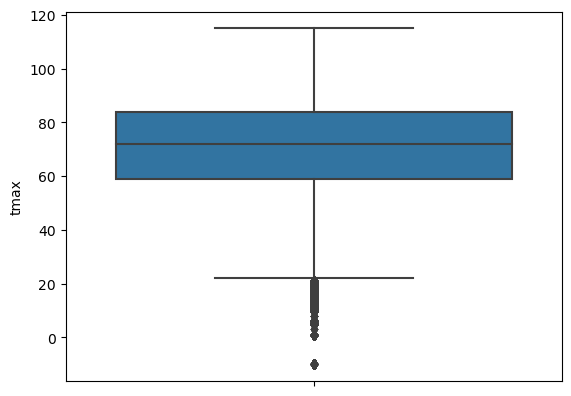

In [35]:
import seaborn as sns

sns.boxplot(y = flight_df['tmax'])

# Obliczenie korelacji:
correlation = flight_df['tmax'].corr(flight_df['dep_delay'])
print(f"Korelacja między temperaturą maksymalną a odsetkiem opóźnień: {correlation:.2f}")

# wnioski: brak korelacji między temperaturą a opoznieniami

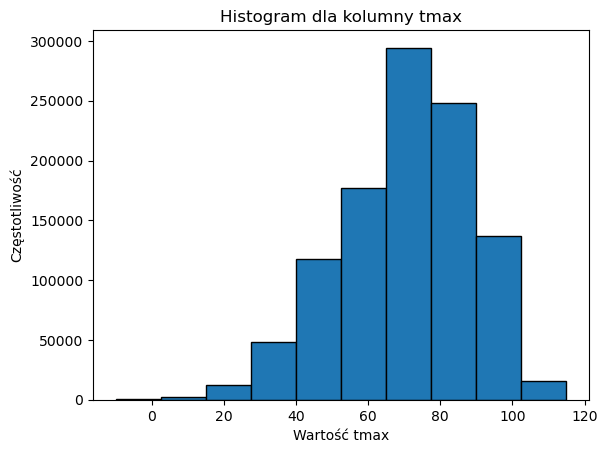

In [36]:
plt.hist(flight_df['tmax'], edgecolor='black')
plt.xlabel('Wartość tmax')
plt.ylabel('Częstotliwość')
plt.title('Histogram dla kolumny tmax')
plt.show()

In [37]:
# średnią wartość opóźnień dla poszczególnych temperatur maksymalnych i częstość występowania tmax

average_delay_by_tmax = flight_df.groupby('tmax')['dep_delay'].agg(['mean', 'count']).reset_index()
average_delay_by_tmax.rename(columns={'mean': 'avg_delay', 'count': 'frequency'}, inplace=True)
average_delay_by_tmax

,tmax,avg_delay,frequency
0,-10.0,70.590551,127
1,1.0,50.623596,178
2,3.0,59.142857,7
3,5.0,43.210169,295
4,6.0,23.881720,186
...,...,...,...
107,111.0,9.759587,678
108,112.0,10.464373,407
109,113.0,10.460000,300
110,114.0,12.331633,588


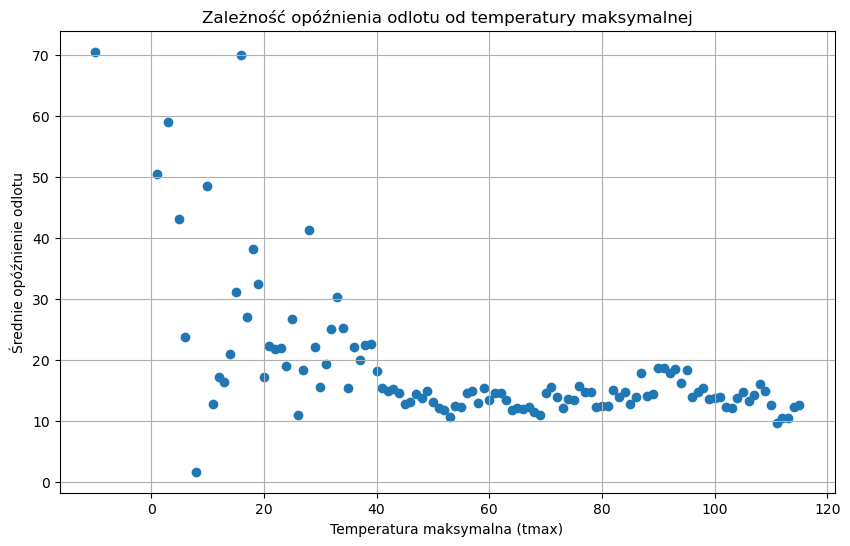

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(average_delay_by_tmax['tmax'], average_delay_by_tmax['avg_delay'])

plt.xlabel('Temperatura maksymalna (tmax)')
plt.ylabel('Średnie opóźnienie odlotu')
plt.title('Zależność opóźnienia odlotu od temperatury maksymalnej')
plt.grid(True)

plt.show()

In [39]:
# procent lotów poniżej 40'C:

filtered_flights = flight_df[flight_df['tmax'] < 40]
percent_below_40 = (len(filtered_flights) / len(flight_df)) * 100

print(f"Procent lotów przy temperaturze poniżej 40'C': {percent_below_40:.2f}%")

Procent lotów przy temperaturze poniżej 40'C': 5.94%


In [40]:
# jaki procent lotów poniżej 40'C jest opozniony?: 

filtered_flights_2 = filtered_flights[filtered_flights['is_delayed']==True]
filtered_flights_40 = (len(filtered_flights_2) / len(filtered_flights)) * 100

print(f"Procent lotów opoznionych przy temperaturze poniżej 40'C': {filtered_flights_40:.2f}%")

Procent lotów opoznionych przy temperaturze poniżej 40'C': 25.69%


# Wnioski: 
Wpływ temperatury na opóźnienia występuje jedynie w przypadku 5,94% lotów. Co świadczy o tym że nie ma istotnej korelacji między opoznieniami a temperaturą. Dla lotów w temperaturze mniejszej niż 40 prawdopodobienstwo wystopienia opoznienia zwieksza sie - w tym przedziale występuje 25.69% opoznien